# SNR Measurements
Author: Lawrence Lechuga <br>
Date: 09/16/2020 <br> 
Overview: Python notebook facilitating SNR measurement application

## ROI selection code
Here I am generating the methods used to allow for the selection of a user-defined ROI polygon. Nothing too relevant to the course material here...

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import IPython.display as Disp
from ipywidgets import widgets
import cv2
import math

class bbox_select():
    %matplotlib notebook 


    def __init__(self,im):
        self.im = im
        self.selected_points = []
        self.fig,ax = plt.subplots()
        self.img = ax.imshow(self.im.copy())
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        disconnect_button = widgets.Button(description="Disconnect mpl")
        Disp.display(disconnect_button)
        disconnect_button.on_click(self.disconnect_mpl)

    def poly_img(self,img,pts):
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(img,[pts],True,(255,0,0),6)
        return img
    def onclick(self, event):
    #display(str(event))
        self.selected_points.append([event.xdata,event.ydata])
        if len(self.selected_points)>1:
            self.fig
            self.img.set_data(self.poly_img(self.im.copy(),self.selected_points))
            
    def disconnect_mpl(self,_):
        self.fig.canvas.mpl_disconnect(self.ka)

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def ROI_analysis(image,bbox_points):
    # calculate a mask of the points and number of bins for hist
    arrs = np.array([bbox_points],int)
    masks = cv2.fillPoly(np.zeros(image.shape,np.uint8),arrs,[1])
    bins = int(np.around(np.sqrt(np.count_nonzero(masks))))
    return (masks, bins)

def Filter2D(image, size, num_slices):
    # image: image to be filtered
    # size: size of the image
    # num_slices: stack size in z
    image = image.astype(float)
    numx = size[0]
    numy = size[1]
    Wfx = np.kaiser(numx,35)
    Wfy = np.kaiser(numy,35)
    Filt = np.outer(Wfx,Wfy)
    X = np.linspace(0, numx, numx)
    Y = np.linspace(0, numy, numy)
    X, Y = np.meshgrid(X, Y)
    # plot the filter
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X,Y,Filt, cmap=cm.viridis,linewidth=0, antialiased=False)
    # Customize the z axis.
    ax.set_zlim(0, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.set_title('Kaiser Filter')
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    I_hat = np.squeeze(np.zeros( (numx, numy,num_slices) ) )
    I_temp = np.squeeze(np.zeros( (numx, numy,num_slices) ) )
    II = np.squeeze(np.zeros( (numx, numy,num_slices) ) )
    
    # Perform filtering
    if image.ndim < 3:
        I_temp = image
        II= np.multiply(Filt,np.fft.fftshift(np.fft.fft2(np.fft.fftshift(I_temp))))
        I_hat = abs(np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(II))))        
    else:
        for ii in range(1,num_slices):
            I_temp[:,:,ii] = image[:,:,ii]
            II[:,:,ii] = np.multiply(Filt,np.fft.fftshift(np.fft.fft2(np.fft.fftshift(I_temp[:,:,ii]))))
            I_hat[:,:,ii] = abs(np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(II[:,:,ii]))))
    return I_hat

## Import Phantom Images
Here we will import two raw images: "Phant_1.bin" and "Phant_2.bin". These are two magnitude realizations of an MRI acquisition of a homogeneous oval-shaped phantom. The raw matrix size is 512 X 512 with unsigned 8 bit depth. Note we need to convert the images to 32 bit floating point for the subtraction operation in order to preserve sign.

<IPython.core.display.Javascript object>


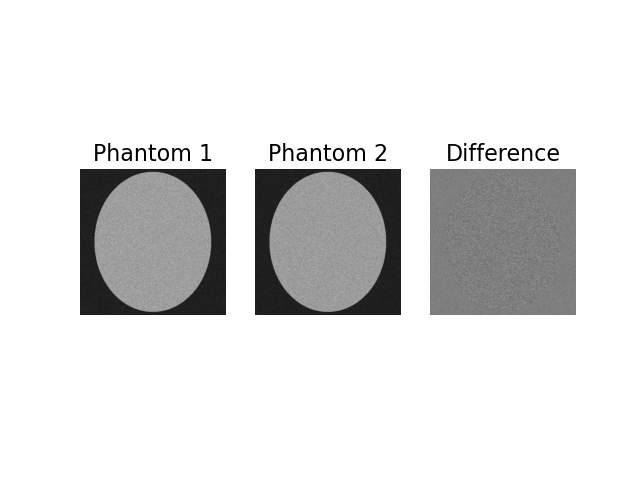

In [2]:
# import phantoms
filename1 = "phantom_data/Phant_1v02.bin"
filename2 = "phantom_data/Phant_2v02.bin"
p1 = np.fromfile(filename1, dtype='uint8', sep="")
p2 = np.fromfile(filename2, dtype='uint8', sep="")
# reshape phantoms, and convert to float32
p1 = p1.reshape([512,512])
p1 = p1.astype(np.float32)
p2 = p2.reshape([512,512])
p2 = p2.astype(np.float32)
pdiff = p1-p2
# plot the phantoms
fig, (ax1, ax2, ax3) = plt.subplots(1,3);
ax1.imshow(p1,cmap='gray')
ax1.set_title('Phantom 1',fontsize=16); ax1.axis('off')
ax2.imshow(p2,cmap='gray')
ax2.set_title('Phantom 2',fontsize=16); ax2.axis('off')
ax3.imshow(pdiff,cmap='gray')
ax3.set_title('Difference',fontsize=16); ax3.axis('off')
plt.show()

# Question 1A:
Lets characterize the noise behavior by plotting the histograms of the signal and background and calculating the respective sample mean and standard deviation.
## Histrograms of the full Phantoms
Here we can characterize, via histograms, the values seen within the phantom images.

<IPython.core.display.Javascript object>


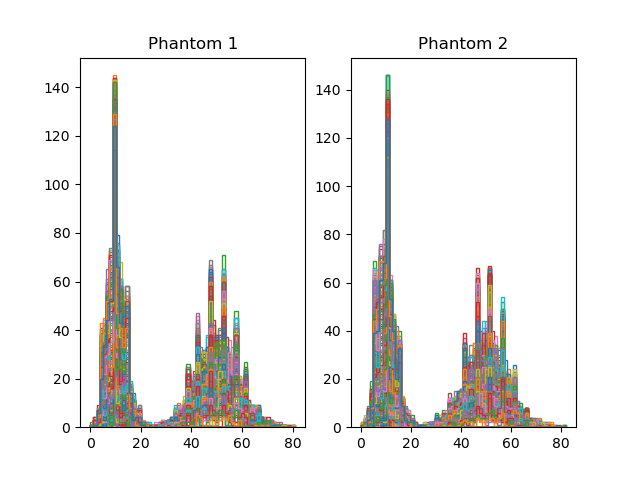

In [3]:
fig_hist,(hist1, hist2) = plt.subplots(1,2)
hist1.hist(p1,bins='auto',histtype='step')
hist1.set_title("Phantom 1")
hist2.hist(p2,bins='auto',histtype='step')
hist2.set_title("Phantom 2")
plt.show()

## Draw ROIs within signal regions of Phantom 1 and 2
For Phantom 1 and 2, we will want to draw ROIs within the signal region. 

***Tip: Select a closed region using mouse clicks for each vertice of the polygon. Then hit the on/off button in the top left corner to complete selection***

<IPython.core.display.Javascript object>


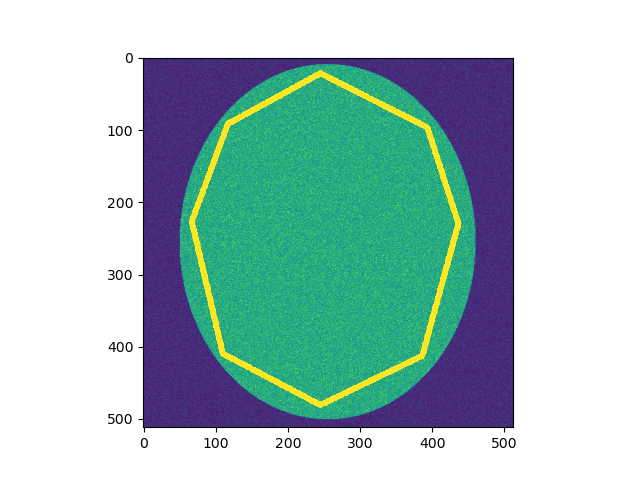

Button(description='Disconnect mpl', style=ButtonStyle())

In [7]:
bs1s = bbox_select(p1)

<IPython.core.display.Javascript object>


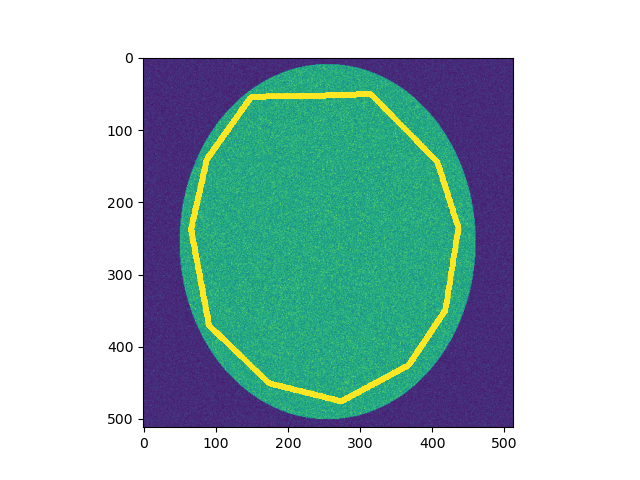

Button(description='Disconnect mpl', style=ButtonStyle())

In [8]:
bs2s = bbox_select(p2)

## Draw ROIs within noise regions of Phantom 1 and 2
For Phantom 1, Phantom 2, and Phantom diff, we will want to draw ROIs within the noise region, devoid of signal. 


<IPython.core.display.Javascript object>


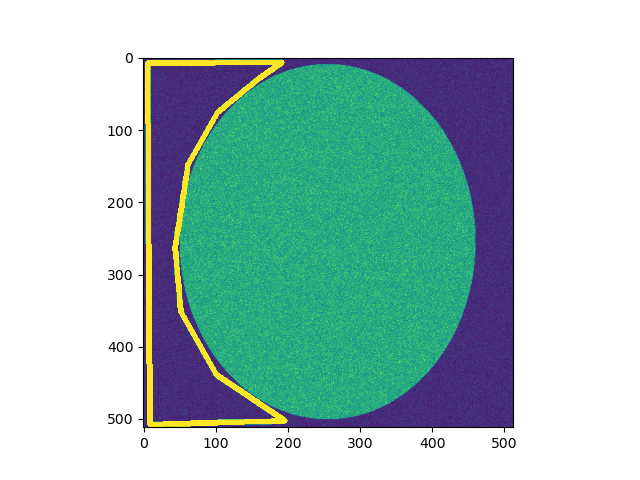

Button(description='Disconnect mpl', style=ButtonStyle())

In [9]:
bs1n = bbox_select(p1)

<IPython.core.display.Javascript object>


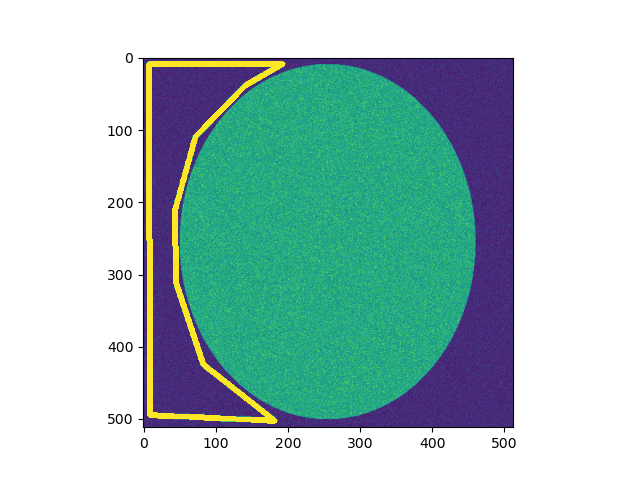

Button(description='Disconnect mpl', style=ButtonStyle())

In [10]:
bs2n = bbox_select(p2)

## Calculate the mean of the ROIs
Here we will calculate the mean and standard deviation of the signal ROIs for phantom 1 and 2

In [11]:
# P1 SIGNAL ROI
mask1s, bin1s  = ROI_analysis(p1,bs1s.selected_points)


# P2 SIGNAL ROI
mask2s, bin2s  = ROI_analysis(p2,bs2s.selected_points)


# Calculate mean and standard deviation for each
mean1s, std1s = weighted_avg_and_std(np.multiply(p1,mask1s), mask1s)
mean2s, std2s = weighted_avg_and_std(np.multiply(p2,mask2s), mask2s)
MeanSig = np.mean([mean1s,mean2s])
print('The mean signal in phantom 1 is: ',round(mean1s,2))
print('The mean signal in phantom 2 is: ',round(mean2s,2))
print('The mean signal between phantom 1 and 2 is: ',round(MeanSig,2))


The mean signal in phantom 1 is:  50.04
The mean signal in phantom 2 is:  49.97
The mean signal between phantom 1 and 2 is:  50.01


## Calculate the mean noise ROIs for Phantoms 1 and 2

In [12]:
# bs1s.selected_points # uncomment if you want to see the points you selected
# P1 NOISE ROI
mask1n, bin1n  = ROI_analysis(p1,bs1n.selected_points)
# P2 NOISE ROI
mask2n, bin2n  = ROI_analysis(p2,bs2n.selected_points)
# Calculate mean and standard deviation for each
mean1n, std1n = weighted_avg_and_std(np.multiply(p1,mask1n), mask1n)
mean2n, std2n = weighted_avg_and_std(np.multiply(p2,mask2n), mask2n)
MeanNoise = np.mean([mean1n,mean2n])

print('The mean noise within phantom 1 is: ',round(mean1n,2))
print('The mean noise within phantom 2 is: ',round(mean2n,2))
print('The mean noise between phantom 1 and 2 is: ',round(MeanNoise,3))

The mean noise within phantom 1 is:  10.01
The mean noise within phantom 2 is:  9.99
The mean noise between phantom 1 and 2 is:  10.004


## Question 1B: Calculate the SNR using multiple methods
### 1. Calculate the SNR of the single magnitude realizations

For our noise measurements, what characteristics does it have? The pure noise within a magnitude image follows a Rayleigh distribution. This will bias our noise measurement and cause an underestimation of our SNR. How do we correct for it?
The relationship between the mean of a rayleigh distribution, $\bar{N}$, and the standard deviation (of a gaussian):
\begin{equation*}
\sigma = \sqrt{\frac{2}{\pi}}\cdot \bar{N}
\end{equation*}

In [13]:
# Correct the noise values
CorrNoise = MeanNoise*np.sqrt(2/np.pi)
SNR1 = MeanSig/CorrNoise
print('Using Method 1 to estimate SNR: \n')
print('The average SNR of magnitude images, phantom 1 and 2 is ',round(SNR1,2) )

Using Method 1 to estimate SNR: 

The average SNR of magnitude images, phantom 1 and 2 is  6.26


### 2. Calculate the SNR using method 2
Estimate SNR from the difference of the two image realizations “Phant_1” and Phant_2” again using an appropriately placed ROI or ROI’s.

First, calculate the noise within the subtracted oval region.

<IPython.core.display.Javascript object>


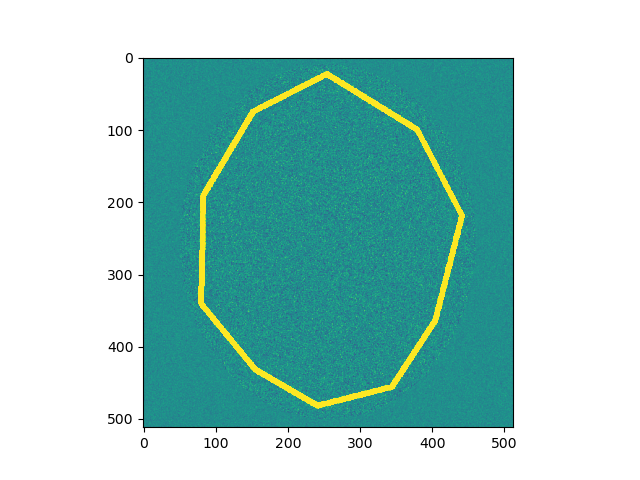

Button(description='Disconnect mpl', style=ButtonStyle())

In [14]:
bs3n = bbox_select(pdiff) # select this ROI within the oval! 

### What does this noise look like?
Lets plot histograms of the noise regions for method 1 and method 2

<IPython.core.display.Javascript object>


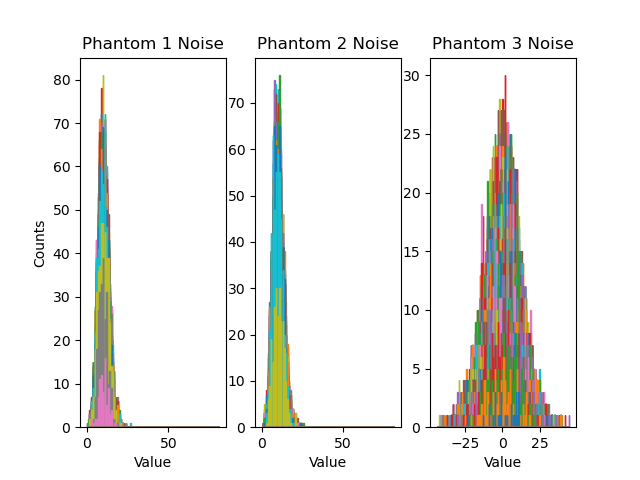

In [16]:
# PDIFF NOISE ROI
mask3n, bin3n  = ROI_analysis(pdiff,bs3n.selected_points)

# arr3n = np.array([bs3n.selected_points],int)
# mask3n = cv2.fillPoly(np.zeros(pdiff.shape,np.uint8),arr3n,[1])
# bin3n = int(np.around(np.sqrt(np.count_nonzero(mask3n))))



fig_noise,(roi_p1,roi_p2,roi_pdiff) = plt.subplots(1,3)
# P1 NOISE ROI hist
roi_p1.hist(p1,bins=bin1n,histtype='step',weights=mask1n)
roi_p1.set_title("Phantom 1 Noise"); roi_p1.set_xlabel("Value"); roi_p1.set_ylabel("Counts");
# P2 NOISE ROI hist
roi_p2.hist(p2,bins=bin2n,histtype='step',weights=mask2n)
roi_p2.set_title("Phantom 2 Noise"); roi_p2.set_xlabel("Value");
# P_diff NOISE ROI hist
roi_pdiff.hist(pdiff,bins=bin3n,histtype='step',weights=mask3n)
roi_pdiff.set_title("Phantom 3 Noise"); roi_pdiff.set_xlabel("Value");
# show
plt.show()

In [17]:
mean3n, std3n = weighted_avg_and_std(np.multiply(pdiff,mask3n), mask3n)
print('The noise mean and standard deviation of phantom diff is: ',round(mean3n,3), round(std3n,2))

The noise mean and standard deviation of phantom diff is:  0.064 9.98


### Calculate the SNR using the difference image method
For our noise measurements, what characteristics does it have? The noise of our subtracted signal region (within the oval) apprears to be approximately zero-mean Gaussian. However, we subtracted two images from one another. How does that operation propagate to our noise? Using the addition/subtraction rule for error propagation we find the relationship between the subtracted noise and the estimated "true" noise to be:

\begin{equation*}
\sigma = \frac{1}{\sqrt{2}} \cdot \sigma_{\text{diff}}
\end{equation*}

In [18]:
CorrNoiseDiff = std3n/np.sqrt(2)
SNR2 = MeanSig/CorrNoiseDiff
print('Using Method 2 to estimate SNR: \n')
print('The average SNR of magnitude images, phantom 1 and 2 is ',round(SNR2,2) )

Using Method 2 to estimate SNR: 

The average SNR of magnitude images, phantom 1 and 2 is  7.08


###  Calculate the SNR using method 3:

First let's filter the original Phant_1 or Phant_2 image (pick which one using the phant_flag feature) by creating a 2D Kaiser Window, as shown in the plot below. Once we have filtered the image, we can substract the filtered image from the original phantom image to create "pfd".  
***Note:*** The Kaiser window function is generated by taking the outer products of 2 1D Kaiser-Bessel windows. 

<IPython.core.display.Javascript object>


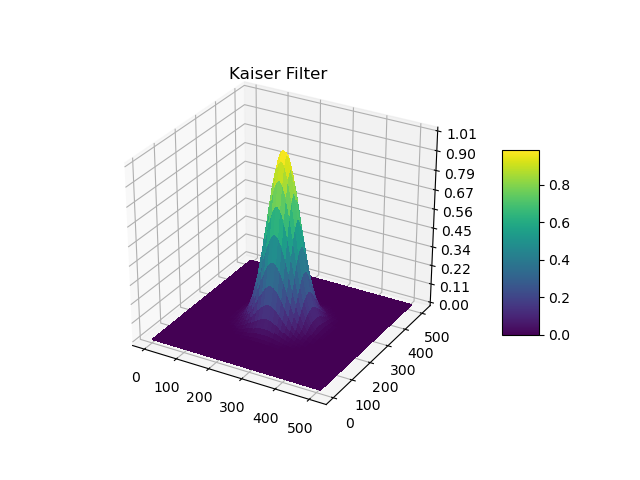

In [19]:
I_hat = Filter2D(p1,p1.shape,1)
phant_flag = 1 # pick which phantom you wish to perform the measurement with.
if phant_flag == 1:
    P = p1
    Mean_sig = mean1s
    P_str = 'Phantom 1'
else:
    P = p2 
    Mean_sig = mean2s    
    P_str = 'Phantom 2'

pfd = P-I_hat

### Plot the resulting images
Now that we have calculated the filterd and filtered-difference image, lets take a look at them and their corresponding histograms.

<IPython.core.display.Javascript object>


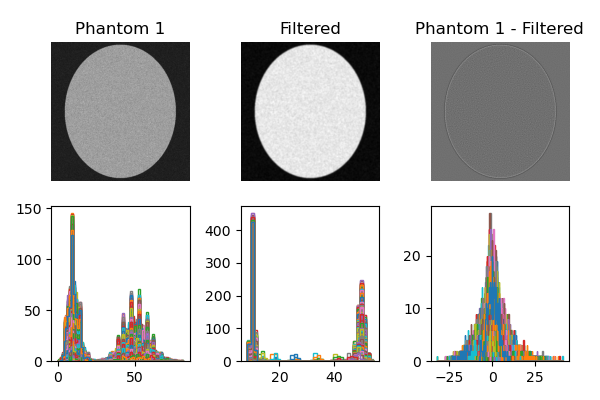

In [21]:
fig, ((ax, ax2, ax3), (hist1, hist2, hist3)) = plt.subplots(2,3,figsize=(6,4))
ax.imshow(p1,cmap='gray'); ax.set_title(P_str)
ax2.imshow(I_hat,cmap='gray'); ax2.set_title('Filtered')
ax3.imshow(pfd,cmap='gray'); ax3.set_title(P_str+' - Filtered')
hist1.hist(p1,bins='auto',histtype='step')
hist2.hist(I_hat,bins='auto',histtype='step')
hist3.hist(pfd,bins='auto',histtype='step')
ax.axis('off');  ax2.axis('off');  ax3.axis('off');
plt.tight_layout()
plt.show()

### Lets calculate the mean and standard deviation in the noise of the filtered difference image
Use the ROI tool to select a region within the oval to determine the average signal within.
Here, we are using the assumption that the noise is largely uncorrelated. Therefore, we can remove most of it by applying a low-pass filter. When we take Phant_1- I_hat, we arrive at what is mostly a noise image (all derived from a single magnitude realization).

The first step here would be to calculate the standard deviation in the noise from Phant_1- I_hat.

<IPython.core.display.Javascript object>


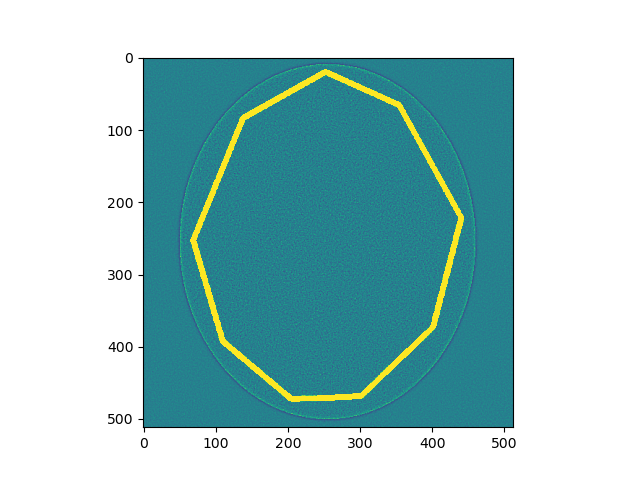

Button(description='Disconnect mpl', style=ButtonStyle())

In [22]:
bs_pfd = bbox_select(pfd) # select this ROI within the oval! 

In [29]:
mask_pfd, bin_pfd  = ROI_analysis(pfd,bs_pfd.selected_points)
# Calculate mean and standard deviation for each
mean_pfd, std_pfd = weighted_avg_and_std(np.multiply(pfd,mask_pfd),mask_pfd)

print('The mean noise in '+ P_str+' - I_hat is: ',round(mean_pfd,3))
print('The std dev of noise in '+ P_str+' - I_hat is: ',round(std_pfd,3))

The mean noise in Phantom 1 - I_hat is:  0.006
The std dev of noise in Phantom 1 - I_hat is:  6.821


### Calculate the SNR from our signal and noise values
We have calculated the "signal" from Phant_1 earlier in this notebook (mean_1s), and we now have our approximate value for noise (std_pfd). 
 
***Mean value within $\textbf{Phant}_1 - \hat{I}$:*** This value is analogous to our noise measurement in method 2. However, we will not need the $\sqrt{2}$ correction here.  
  
Lets calculate SNR for thid set of values

In [33]:
# SNR for Method 3
# Correct the noise values

SNR3 = Mean_sig/std_pfd
print('Using Method 3.2 to estimate SNR:')
print('The average SNR of magnitude images, phantom ',round(SNR3,2),' \n' )

Using Method 3.2 to estimate SNR:
The average SNR of magnitude images, phantom  7.34  



## Report SNR values:
Lets review all the SNR values here!

In [34]:
print('The SNR for methods 1-3 are: ')
print('SNR for method 1: ',round(SNR1,2))
print('SNR for method 2: ',round(SNR2,2))
print('SNR for method 3: ',round(SNR3,2))

The SNR for methods 1-3 are: 
SNR for method 1:  6.26
SNR for method 2:  7.08
SNR for method 3:  7.34
